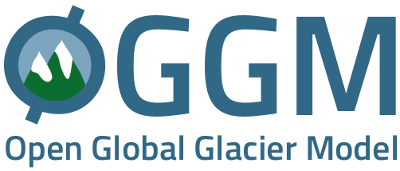

# Using alternative topographical datasets with OGGM

There are a number of datasets available [out-of-the box](https://rgitools.readthedocs.io/en/latest/dems.html) in OGGM. We made a choice about which to use for each region (see our [GMD paper](https://www.geosci-model-dev.net/12/909/2019/gmd-12-909-2019.html)), and this is the DEM which is available in the standard OGGM [pre-processed directories](https://docs.oggm.org/en/v1.1/input-data.html#pre-processed-directories). 

However, it is possible to choose from other data sources, and also to use your own DEM data in OGGM. This is what this tutorial is about. 

## Set-up 

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
cfg.initialize(logging_level='WORKFLOW')

2019-06-13 13:26:44: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/oggm/oggm/params.cfg


## RGI outlines 

Let's use the Hintereisferner glacier as an example here. If you haven't downloaded the RGI files yet, this will download them:

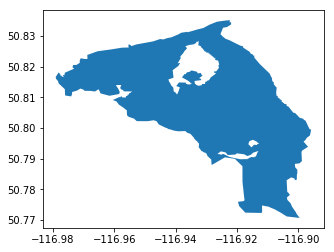

In [2]:
entity = utils.get_rgi_glacier_entities(['RGI60-02.02171'])
entity.plot();

## The default 

If not specifying anything, OGGM will use it's default settings, i.e. SRTM in these latitudes:

In [3]:
cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = 30

In [4]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = '/home/pelto/oggm_runs/conrad_SRTM_30m' #if using gettempdir('default'), cfg.PARAMS are overridden
gdir = workflow.init_glacier_regions(entity)[0]

2019-06-13 13:26:45: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-06-13 13:26:45: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


You can access the (reprojected and interpolated) DEM file in the working directory:

In [5]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (235, 278)
  Grid (dx, dy): (30.0, -30.0)

In [6]:
dem_path = gdir.get_filepath('dem')
dem_path

'/home/pelto/oggm_runs/conrad_SRTM_30m/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

It is a geotiff file. [Xarray](http://xarray.pydata.org) can open them thanks to [rasterio](https://rasterio.readthedocs.io):

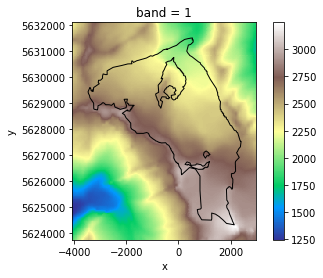

In [7]:
da1 = dem_path
da = xr.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

The source of the DEM is documented in the directory itself:

In [8]:
with open(gdir.get_filepath('dem_source'), 'r') as f:
    print(f.read())

SRTM V4

Original resolution: 3 arcsec (~90m)

# Data Citation

We kindly ask  any users to  cite this data  in any published  material
produced using this data, and if possible link web pages to the CIAT-CSI
SRTM website (http://srtm.csi.cgiar.org).

Citations should be made as follows:

Jarvis A., H.I. Reuter, A.  Nelson, E. Guevara, 2008, Hole-filled seamless SRTM
data V4, International  Centre for Tropical  Agriculture (CIAT), available
from http://srtm.csi.cgiar.org,


# Data files

srtm_13_02.tif



In [9]:
list_talks = [
         tasks.glacier_masks,
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_line,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdir)

2019-06-13 13:26:46: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-06-13 13:26:46: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-06-13 13:26:46: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-06-13 13:26:46: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-06-13 13:26:56: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-06-13 13:26:57: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2019-06-13 13:26:57: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-06-13 13:26:57: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers


In [10]:
workflow.execute_entity_task(tasks.process_cru_data, gdir);

2019-06-13 13:26:57: oggm.workflow: Execute entity task process_cru_data on 1 glaciers


In [11]:
fpath = gdir.get_filepath('climate_monthly')
#ds = xr.open_dataset(fpath)
# Data is in hydrological years
# -> let's just ignore the first and last calendar years
#ds.temp.resample(time='AS').mean()[1:].plot(); #only ignored the first calendar year

In [12]:
workflow.execute_entity_task(tasks.local_t_star, gdir);
workflow.execute_entity_task(tasks.mu_star_calibration, gdir);

2019-06-13 13:26:58: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2019-06-13 13:26:58: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [13]:
from oggm.core.massbalance import MultipleFlowlineMassBalance
gdir_hef = gdir
mbmod = MultipleFlowlineMassBalance(gdir_hef, use_inversion_flowlines=True)

In [14]:
#Computing the ice thickness (Inversion)
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdir)

2019-06-13 13:26:58: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2019-06-13 13:26:58: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2019-06-13 13:26:58: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers


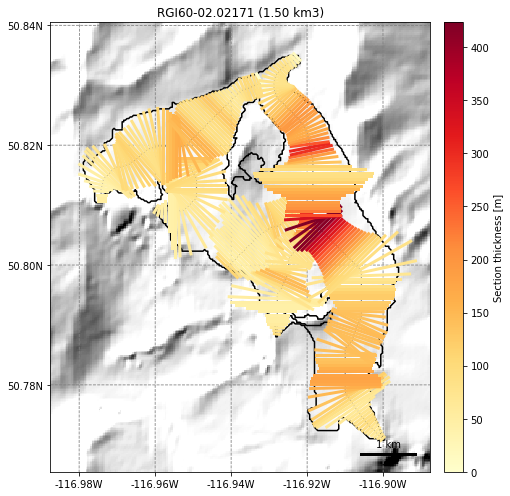

In [15]:
graphics.plot_inversion(gdir, figsize=(8, 7)) #vmax=400
#plt.savefig('conrad_thick_10m_user2014.png')

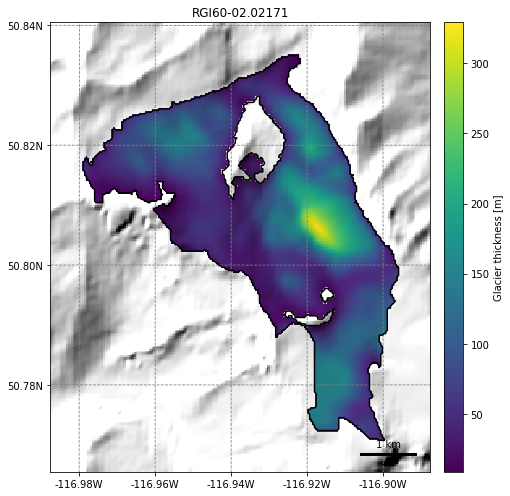

In [16]:
tasks.distribute_thickness_per_altitude(gdir)
graphics.plot_distributed_thickness(gdir, figsize=(8, 7))

In [17]:
utils.compile_glacier_statistics(gdir, inversion_only=True)

2019-06-13 13:27:02: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m,dem_source,n_orig_centerlines,perc_invalid_flowline
rgi_id,,,,,,,,,,,,,,,,
RGI60-02.02171,02,02-03,,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.502077,88.890805,1.658641,98.156069,SRTM,5,0.0


## User provided DEM 

Users should be able to use any DEM file which can be opened by rasterio (i.e. geotiff). Here, we use a subset SRTM file shipped with OGGM as an example:

In [18]:
cust_path = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/'
custom_dem_path = cust_path + '050731_conrad_airphoto_dem1_slave_fill.tif' #'20160912_conrad_dem1_clip_slave.tif'  
custom_dem_path

'/home/pelto/Desktop/lidar_cbt_analysis/conrad/050731_conrad_airphoto_dem1_slave_fill.tif'

We tell OGGM to use it by changing the entry in the RGI table and by giving the path to the file:

In [19]:
cfg.PATHS['dem_file'] = custom_dem_path
entity['DEM_SOURCE'] = 'USER'

In [20]:
WORKING_DIR_USER = '/home/pelto/oggm_runs/conrad_DEM_05_airphoto_30m' #Conrad_DEM_16f_90m
cfg.PATHS['working_dir'] = WORKING_DIR_USER
cfg.PARAMS['grid_dx_method'] = 'fixed'
cfg.PARAMS['fixed_dx'] = 30
gdir = workflow.init_glacier_regions(entity)[0]

Now the user provided DEM is used:

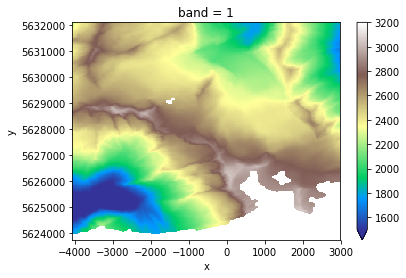

In [21]:
da_user1 = gdir.get_filepath('dem')
da_user = xr.open_rasterio(gdir.get_filepath('dem'))
da_user.plot(cmap='terrain', vmax=3200, vmin=1500);

In [22]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (235, 278)
  Grid (dx, dy): (30.0, -30.0)

In [23]:
list_talks = [
         tasks.glacier_masks,
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_line,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdir)

2019-05-28 14:06:26: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-05-28 14:06:26: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/oggm/oggm/core/gis.py:487: RuntimeWarning: invalid value encountered in less_equal
  dem[dem <= min_z] = np.NaN
2019-05-28 14:06:27: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-05-28 14:06:27: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-05-28 14:06:27: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-05-28 14:06:38: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-05-28 14:06:39: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2019-05-28 14:06:39: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-05-28 14:06:39: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers


In [24]:
da1

'/home/pelto/oggm_runs/conrad_SRTM_30m/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

In [25]:
da_user1

'/home/pelto/oggm_runs/conrad_DEM_05_airphoto_30m/per_glacier/RGI60-02/RGI60-02.02/RGI60-02.02171/dem.tif'

In [26]:
import os
from osgeo import gdal
os.system('gdal_calc.py ' + '-A ' + da1 + ' -B ' + da_user1 + ' --outfile=' + WORKING_DIR_USER + '/SRTM_diff.tif ' + '--calc="B-A"' )

0

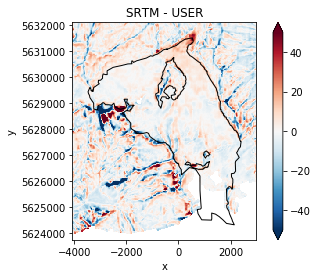

In [27]:
f, ax = plt.subplots()
diff = da - da_user  #print(type(diff))
(diff).plot(ax=ax, vmax=50);
plt.title('SRTM - USER');
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In [28]:

# ds = gdal.Open(cust_path + 'conrad_2014_extent.tif', gdal.GA_ReadOnly)
# band = ds.GetRasterBand(1)
# msk = band.ReadAsArray()  
# msk[np.isnan(msk)] = -9999
# del ds

In [29]:
#define glacier mask
fpath = gdir.get_filepath('gridded_data')
with utils.ncDataset(fpath) as nc:
    topo = nc.variables['topo'][:]
    mask_ext = nc.variables['glacier_ext'][:]
    mask_glacier = nc.variables['glacier_mask'][:]

In [30]:
ds = gdal.Open(WORKING_DIR_USER + '/SRTM_diff.tif' , gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
dh_dt = band.ReadAsArray()
SRTM_diff = dh_dt[np.where(mask_glacier)] #dh_dt[msk == 1]

In [31]:
std = np.nanstd(SRTM_diff)
SRTM_diff = np.nanmean(SRTM_diff)
print(SRTM_diff, ' +/- ', std)

-0.91532415  +/-  7.3434634


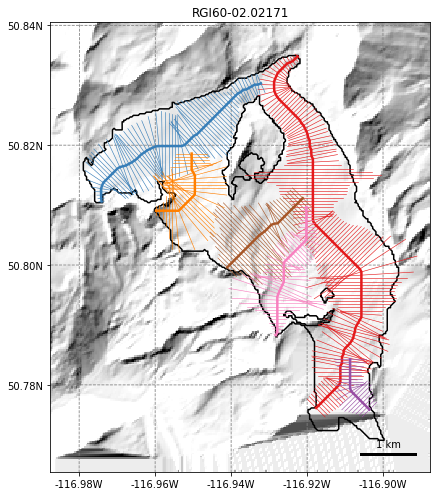

In [32]:
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))
# fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')



In [33]:
import os
print(os.listdir(gdir.dir)) 
#For a short explanation of what these files are, see the glacier directory documentation. In practice, however, you should not need to read these files yourself.

['intersects.tar.gz', 'dem_source.txt', 'downstream_line.pkl', 'diagnostics.json', 'outlines.tar.gz', 'inversion_flowlines.pkl', 'dem.tif', 'intersects.tar.gz.properties', 'glacier_grid.json', 'outlines.tar.gz.properties', 'gridded_data.nc', 'geometries.pkl', 'centerlines.pkl', 'log.txt']


In [34]:
workflow.execute_entity_task(tasks.process_cru_data, gdir);

2019-05-28 14:06:41: oggm.workflow: Execute entity task process_cru_data on 1 glaciers


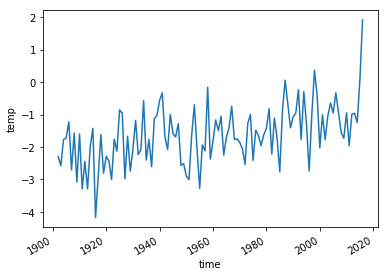

In [35]:
fpath = gdir.get_filepath('climate_monthly')
ds = xr.open_dataset(fpath)
# Data is in hydrological years
# -> let's just ignore the first and last calendar years
ds.temp.resample(time='AS').mean()[1:].plot(); #only ignored the first calendar year

In [36]:
workflow.execute_entity_task(tasks.local_t_star, gdir);
workflow.execute_entity_task(tasks.mu_star_calibration, gdir);

2019-05-28 14:06:42: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2019-05-28 14:06:42: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [37]:
from oggm.core.massbalance import MultipleFlowlineMassBalance
gdir_hef = gdir
mbmod = MultipleFlowlineMassBalance(gdir_hef, use_inversion_flowlines=True)

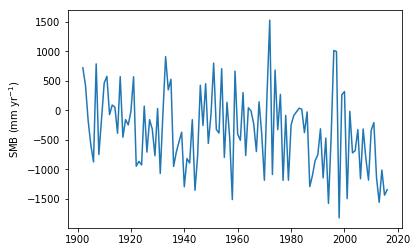

In [38]:
import numpy as np
import matplotlib.pyplot as plt
years = np.arange(1902, 2017)
mb_ts = mbmod.get_specific_mb(year=years)
plt.plot(years, mb_ts); plt.ylabel('SMB (mm yr$^{-1}$)');

In [39]:
print(years, mb_ts)

[1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915
 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929
 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943
 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957
 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971
 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016] [  722.02434489   421.04836219  -179.24299042  -587.78536104
  -872.8853032    788.14264352  -747.54294494  -147.81721896
   463.9771362    577.15210465   -72.0668501     90.35280663
    54.48790221  -387.64193559   571.29608214  -454.0806715
  -155.77140347  -246.44682582   -19.64127524   569.43883406
  -945.8180661   -863.92585138  -924.07731417    72.65959834
  -706.99499764  -157.75454856  -316.73889879  -76

In [40]:
#Computing the ice thickness (Inversion)
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdir)

2019-05-28 14:06:42: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2019-05-28 14:06:42: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2019-05-28 14:06:42: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers


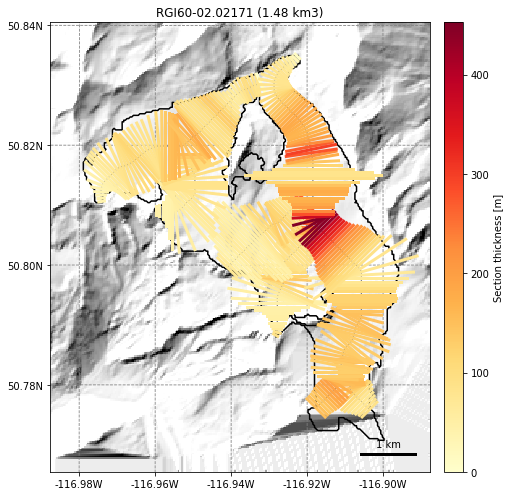

In [41]:
graphics.plot_inversion(gdir, figsize=(8, 7))
#plt.savefig('conrad_thick_10m_user2014.png')

/home/pelto/anaconda2/envs/oggm_env/oggm/oggm/core/gis.py:931: RuntimeWarning: invalid value encountered in sqrt
  slope = np.arctan(np.sqrt(sy**2 + sx**2))


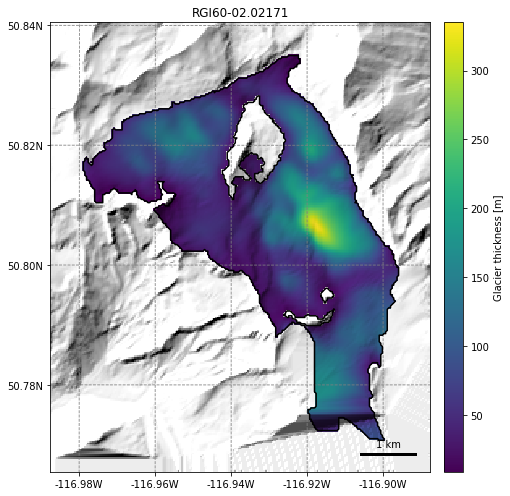

In [42]:
tasks.distribute_thickness_per_altitude(gdir)
#distribute_thickness_interp(gdir)
graphics.plot_distributed_thickness(gdir, figsize=(8, 7))

In [43]:
cfg.PARAMS['inversion_glen_a']

2.4e-24

In [44]:
cfg.PARAMS['grid_dx_method']

'fixed'

In [45]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-02.02171
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 16.898 km2
  Lon, Lat: (-116.93, 50.8069)
  Grid (nx, ny): (235, 278)
  Grid (dx, dy): (30.0, -30.0)

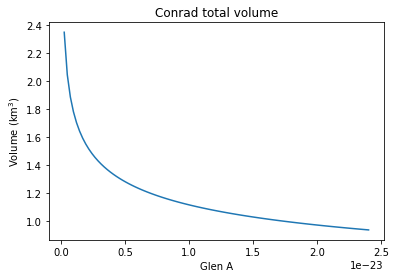

In [46]:
a_factor = np.linspace(0.1, 10., 100) * cfg.PARAMS['inversion_glen_a']
volume = []
for f in a_factor:
    v, _ = tasks.mass_conservation_inversion(gdir, glen_a=f, write=False)
    volume.append(v * 1e-9)
plt.plot(a_factor, volume); plt.title('Conrad total volume');
plt.ylabel('Volume (km$^3$)'); plt.xlabel('Glen A'); 

In [47]:
utils.compile_glacier_statistics(gdir, inversion_only=True)

2019-05-28 14:06:46: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m
rgi_id,,,,,,,,,,,,,
RGI60-02.02171,02,02-03,,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.482345,87.723083,1.658641,98.156069


In [48]:
import pandas as pd
df = pd.read_csv(os.path.join(WORKING_DIR_USER, 'glacier_statistics.csv'), index_col=0)
df

,rgi_region,rgi_subregion,name,cenlon,cenlat,rgi_area_km2,glacier_type,terminus_type,status,inv_volume_km3,inv_thickness_m,vas_volume_km3,vas_thickness_m
rgi_id,,,,,,,,,,,,,
RGI60-02.02171,2,02-03,NaN,-116.93,50.8069,16.898,Glacier,Land-terminating,Glacier or ice cap,1.482345,87.723083,1.658641,98.156069


In [49]:
# ax1 = graphics.plot_distributed_thickness(gdir, figsize=(8, 7))
# f, axs = plt.subplots(2, 2, figsize=(8, 6))


In [50]:
#dir()

In [51]:
#'glacier_mask'

## What's next?

You have several options from here:
- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)

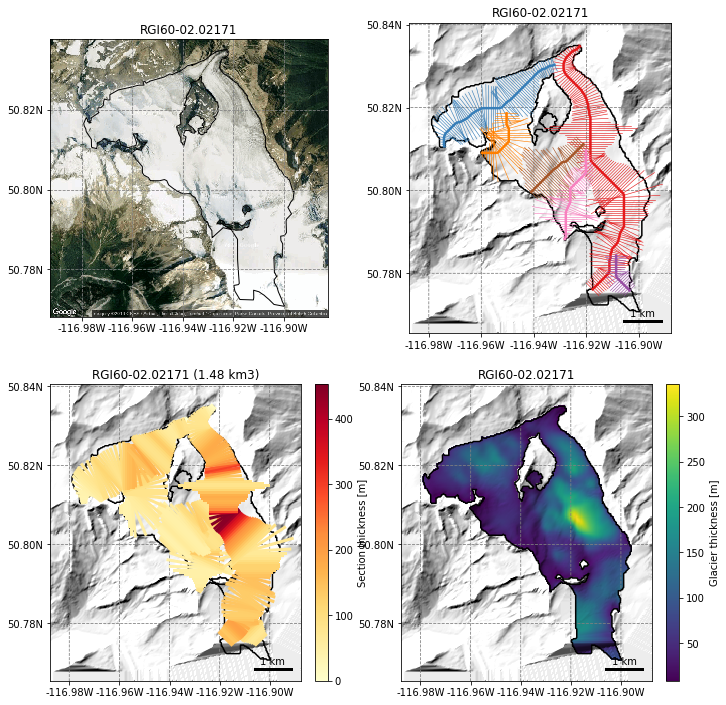

In [52]:
# # row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10)) #sharex='col', sharey='row', sharex=True, sharey=True,
graphics.plot_catchment_width(gdir, corrected=True, ax=ax2)
graphics.plot_googlemap(gdir, ax=ax1)
graphics.plot_distributed_thickness(gdir, ax=ax4)
graphics.plot_inversion(gdir, ax=ax3) #vmax=400
plt.tight_layout()
plt.savefig(WORKING_DIR_USER + '/conrad_four_panel_90m.png')
